# Librerias necesarias

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor



# Cargamos la Data

In [37]:

#Aqui se setea la ruta donde tengamos guardado el archivo
file_path = 'dataset_Caso_1.csv'
caso_1 = pd.read_csv(file_path)

## Paso 1: Analisis Exploratorio de la Data (EDA)

In [38]:
print("Estructura de la Data:")
print(caso_1.info())
print("\nValores Faltantes:")
print(caso_1.isnull().sum())
print("\nEstadísticas Descriptivas:")
print(caso_1.describe())

#Con esto nos damos cuenta del tipo de dato que es cada variable y tambien de que no existen datos faltantes, dado que
#no existe mayor contexto sobre la data asumiremos que las estadísticas obtenidas se encuentran dentro de rangos aceptables.

Estructura de la Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      2000 non-null   float64
 1   x2      2000 non-null   float64
 2   x3      2000 non-null   object 
 3   x4      2000 non-null   object 
 4   x5      2000 non-null   int64  
 5   x6      2000 non-null   int64  
 6   x7      2000 non-null   int64  
 7   x8      2000 non-null   float64
 8   target  2000 non-null   int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 140.8+ KB
None

Valores Faltantes:
x1        0
x2        0
x3        0
x4        0
x5        0
x6        0
x7        0
x8        0
target    0
dtype: int64

Estadísticas Descriptivas:
                x1           x2          x5           x6           x7  \
count  2000.000000  2000.000000  2000.00000  2000.000000  2000.000000   
mean    101.074885  -298.282145     0.01250     0.027000     3.440500   
std    

## Paso 2: Distribución de las variables numéricas


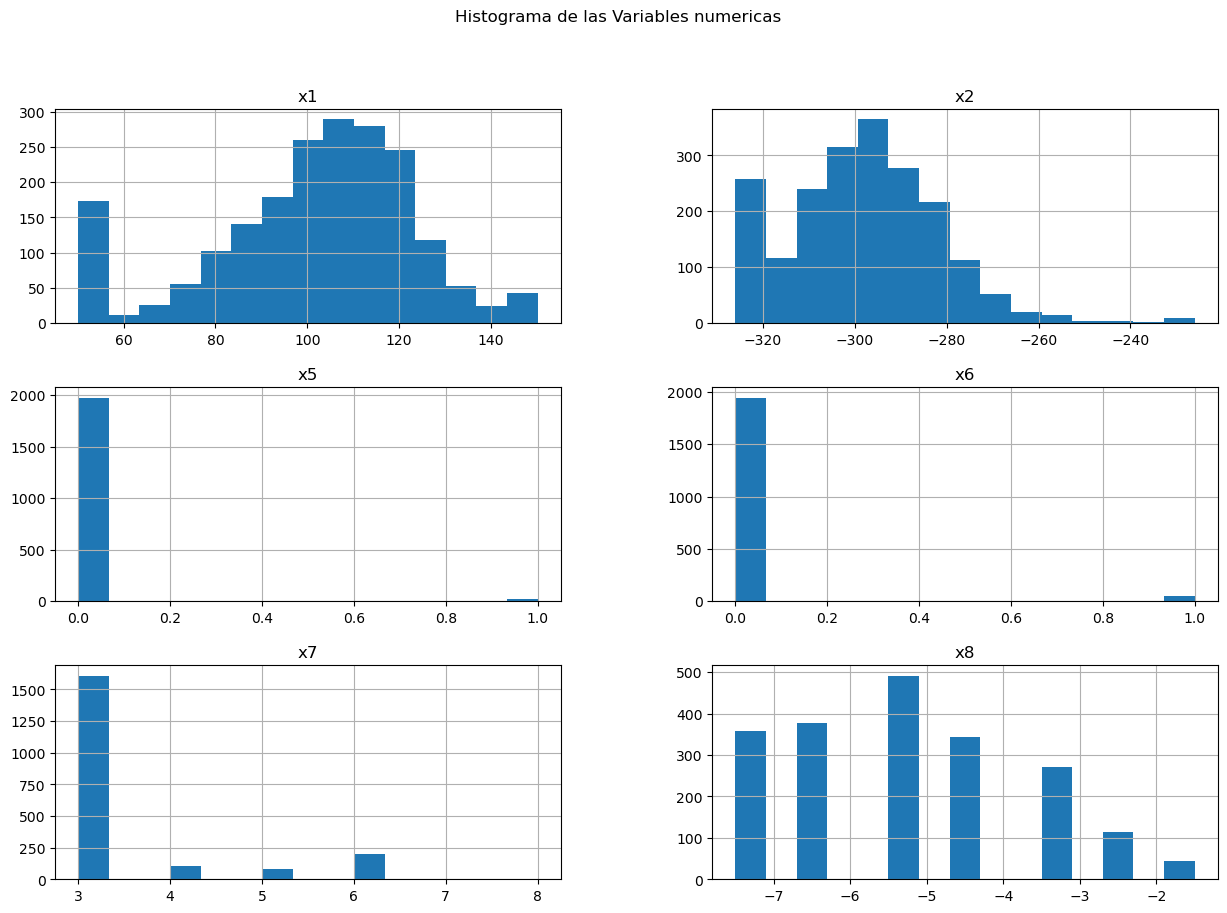

In [44]:

variables_numericas = caso_1.select_dtypes(include=['float64', 'int64']).columns

excluir = 'target'  # Excluimos la variable dependiente

variables_numericas = [col for col in variables_numericas if col != excluir]

# Generamos un histograma para cada variable
caso_1[variables_numericas].hist(bins=15, figsize=(15, 10))
plt.suptitle('Histograma de las Variables numericas')
plt.show()


## Paso 3: Variables Categoricas


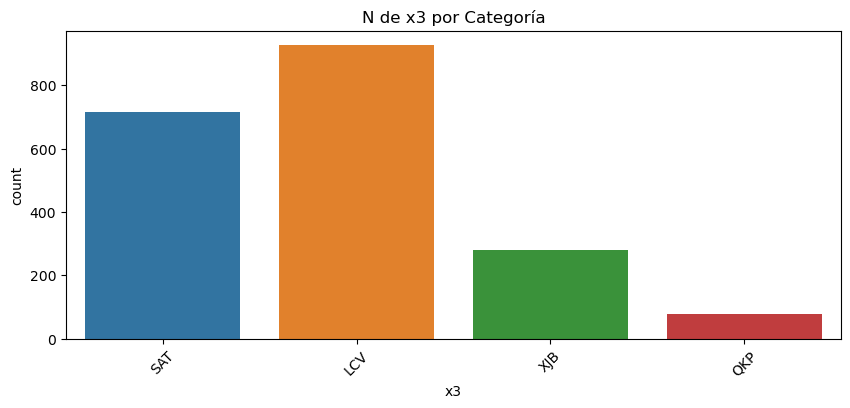

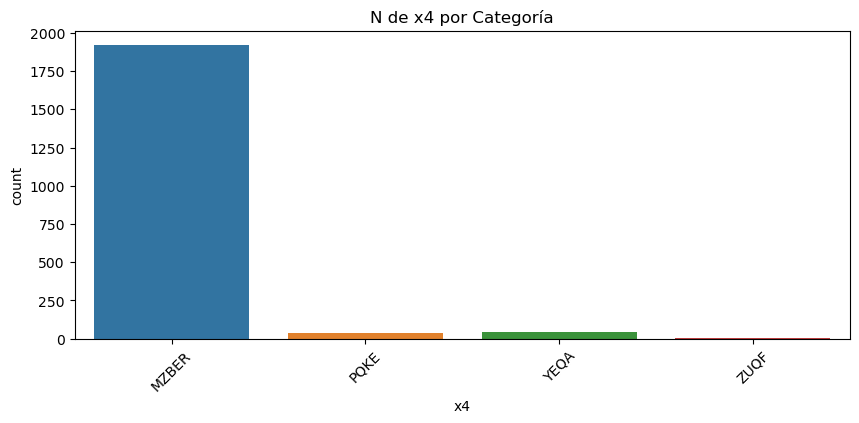

In [45]:

variables_categoricas = caso_1.select_dtypes(include=['object']).columns

for col in variables_categoricas:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=caso_1, x=col)
    plt.title(f'N de {col} por Categoría')
    plt.xticks(rotation=45)
    plt.show()



# Paso 4: Matriz de Correlación

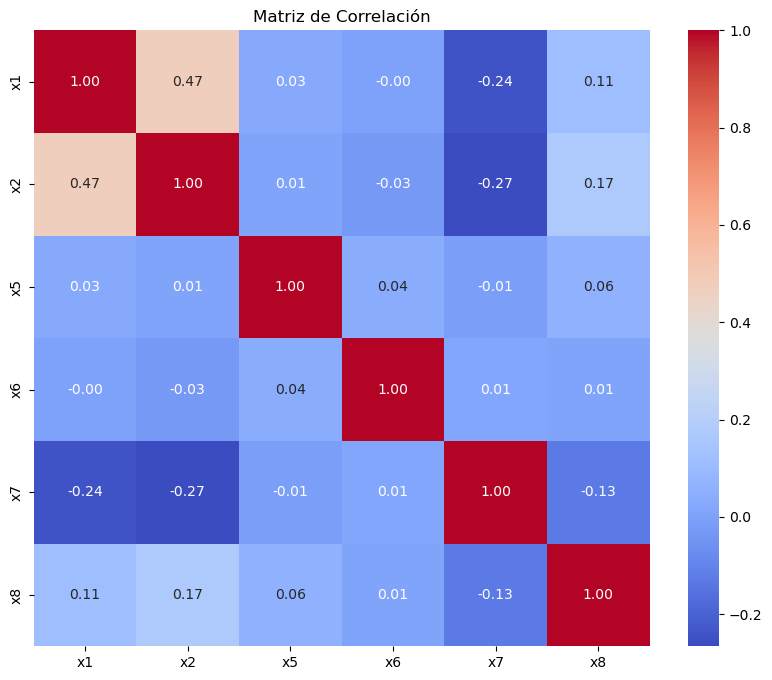

In [46]:

correlation_matrix = caso_1[variables_numericas].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Matriz de Correlación')
plt.show()


# Paso 6: Pairplot para ver las relaciones entre las variables


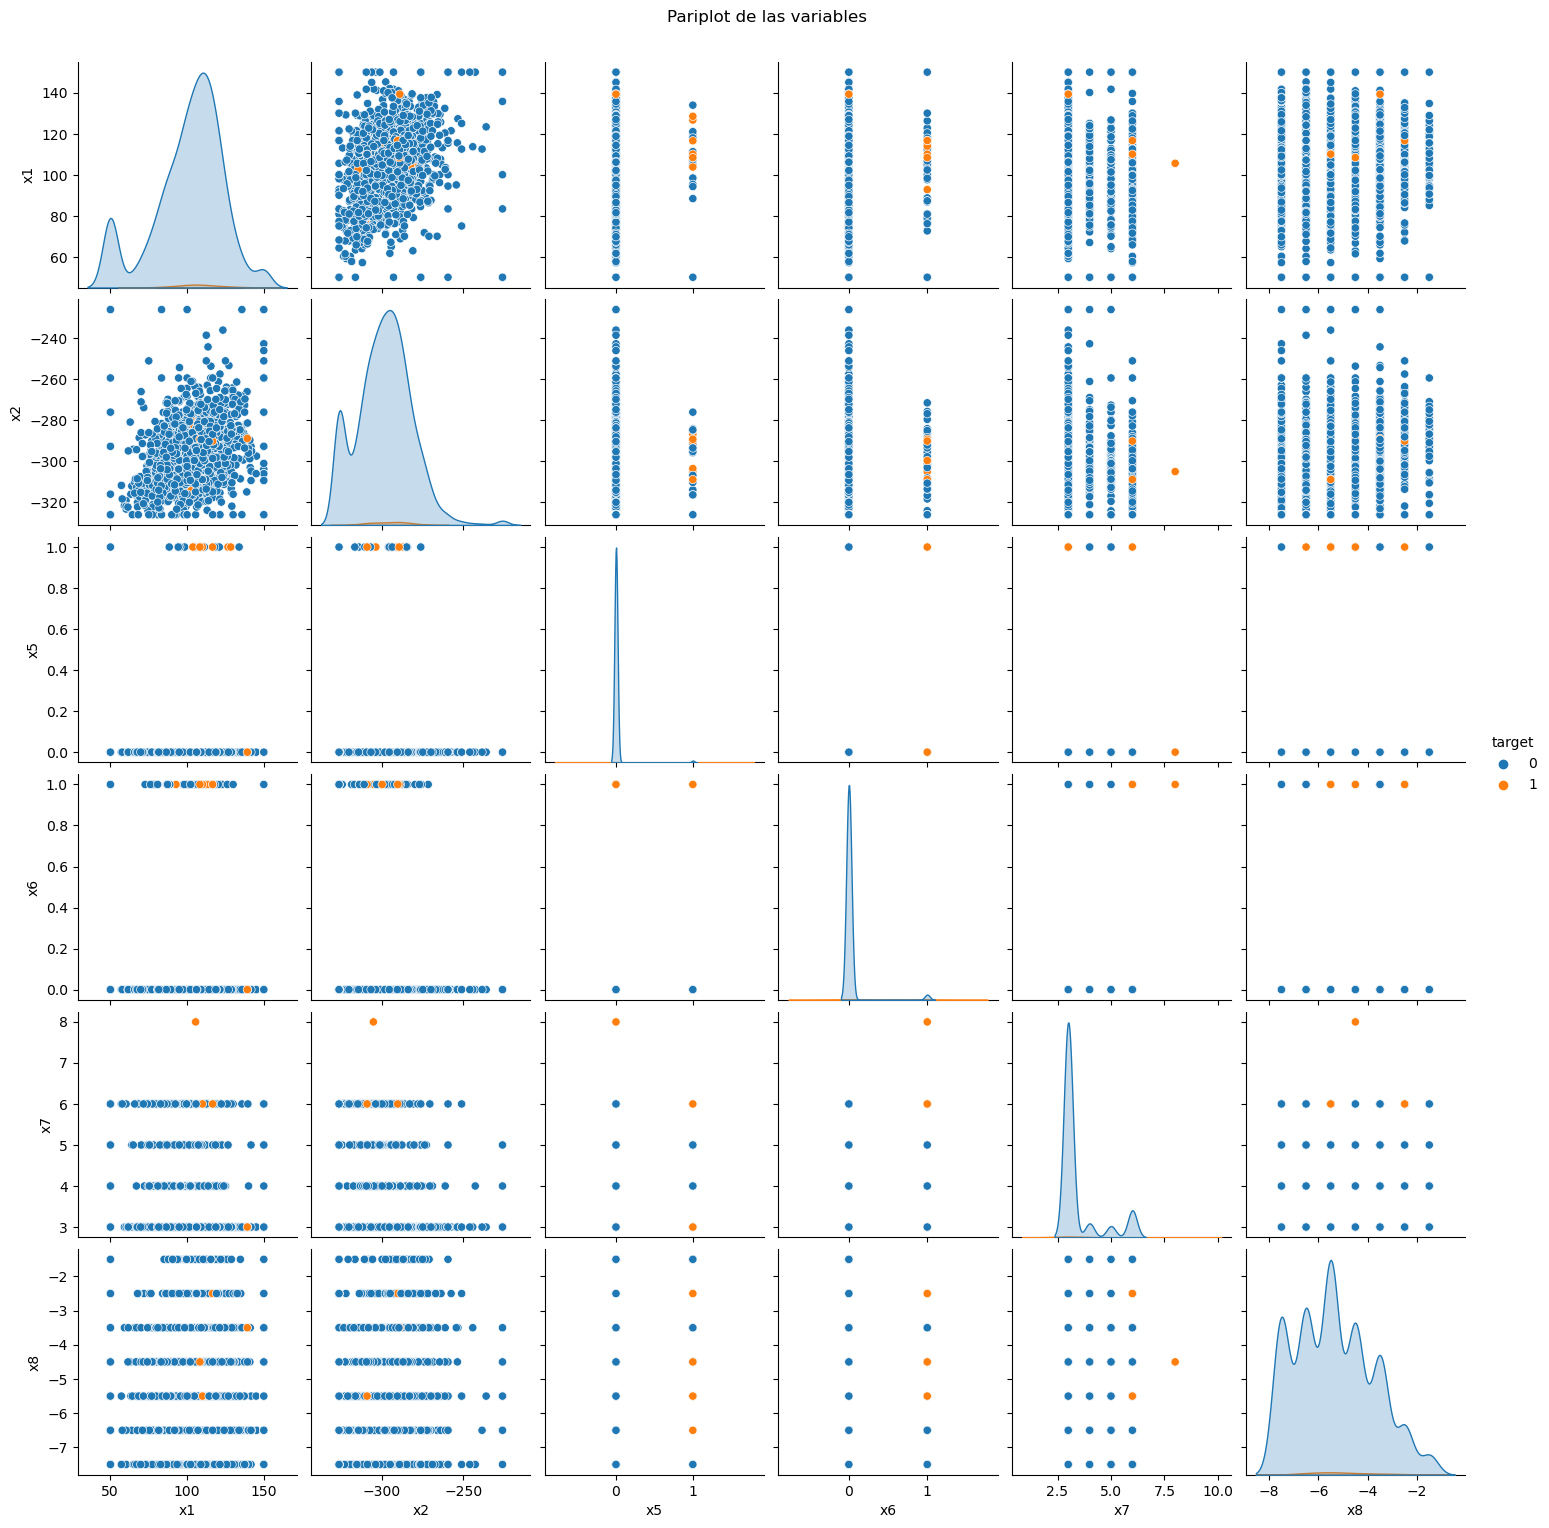

In [47]:

sns.pairplot(caso_1, hue='target', diag_kind='kde')
plt.suptitle('Pariplot de las variables', y=1.02)
plt.show()
#Tal como podemos apreciar en la matriz de correlación, se podria llegar a decir que existe algun tipo de grado de relación entre la variable x1 y x2
#pero no llega a ser lo suficientemente alto como para tener que hacer algun tipo de desarrollo para eliminarlo.

# Selección de Variables

## Analisís de Balanceo

In [48]:
X = caso_1.drop('target', axis=1)  # Variables Independientes
y = caso_1['target']                # Variable Dependiente

# Nos aseguramos de que no existan valores Faltantes
X.fillna(0, inplace=True)

# Generamos un encoding de las variables categóricas para poder incluirlas en todos los modelos
X = pd.get_dummies(X, drop_first=True)

y_counts = y.value_counts()

#Con esto nos damos cuenta que claramente existe un desbalanceo entre las clases
print("N de valores de y:")
print(y_counts)

# Compramos las clases
category_1 = '0'  
category_2 = '1'  

# Extramos el N por categoría
count_1 = y_counts.get(category_1, 0) 
count_2 = y_counts.get(category_2, 1)

# Generamos una condición para que en caso de existir una diferencia mayor al 60% debemos generar un balanceo de las datas
if count_2 > 0: 
    if count_1 > count_2 * 1.6:  
        result_variable = f"La categoría {category_1} es mayor que la categoría {category_2} por mas de un 60%."
    elif count_2 > count_1 * 1.6: 
        result_variable = f"La categoría {category_2} es mayor que la categoría {category_1} por mas de un 60%."
    else:
        result_variable = f"Ninguna categoría es mayor que la otra por mas de un 60%."
else:
    result_variable = f"No se puede comparar."

print(result_variable)
# Con esto sabemos que es necesario aplicar algun tipo de remuestreo para que los modelos tengan una performance aceptable

N de valores de y:
0    1978
1      22
Name: target, dtype: int64
La categoría 1 es mayor que la categoría 0 por mas de un 60%.


## Balanceo de las clases

In [49]:
# Para lidiar con el desvalanceo de la variable dependiente utilizaremos el metodo de SMOTEE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


# Selección de Variables 

## Regresión Lasso

In [51]:
# Estandarizamos las variables 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Ajustamos la regresión Lasso
lasso = Lasso(alpha=0.01) 
lasso.fit(X_scaled, y_resampled)

# Extraemos los coeficientes de Lasso
lasso_coef = lasso.coef_

# Crear un DataFrame para ver las características seleccionadas por Lasso
selected_features = pd.DataFrame({'Variable': X.columns, 'Coeficiente': lasso_coef})
selected_features = selected_features[selected_features['Coeficiente'] != 0]

print("\nVariables Seleccionadas con Lasso:")
print(selected_features)



Variables Seleccionadas con Lasso:
   Variable  Coeficiente
0        x1     0.013634
1        x2     0.012871
2        x5     0.109355
3        x6     0.082555
4        x7    -0.001746
6    x3_QKP    -0.018372
7    x3_SAT    -0.182290
8    x3_XJB    -0.122181
9   x4_PQKE    -0.019329
10  x4_YEQA    -0.003380


# Utilizando el metodo de VIF

In [56]:

# Filtramos solo las columnas seleccionadas por Lasso
selected_columns = selected_features['Variable'].values
X_lasso_selected = pd.DataFrame(X_scaled, columns=X.columns)[selected_columns]

# Función para calcular VIF
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Calcular el VIF solo para las características seleccionadas por Lasso
vif_data = calculate_vif(X_lasso_selected)
print("\nVIF de las Variables Seleccionadas con Lasso:")
print(vif_data)

# Filtrar características basadas en el VIF
high_vif_features = vif_data[vif_data["VIF"] > 10]  # Umbral ajustable
features_to_keep = selected_features[~selected_features['Variable'].isin(high_vif_features['Variable'])]

print("\nVariables Seleccionadas con VIF:")
print(features_to_keep)



VIF de las Variables Seleccionadas con Lasso:
  Variable       VIF
0       x1  1.294475
1       x2  1.292963
2       x5  1.051320
3       x6  1.168221
4       x7  1.159453
5   x3_QKP  1.104720
6   x3_SAT  1.123200
7   x3_XJB  1.054414
8  x4_PQKE  1.045518
9  x4_YEQA  1.019517

Variables Seleccionadas con VIF:
   Variable  Coeficiente
0        x1     0.013634
1        x2     0.012871
2        x5     0.109355
3        x6     0.082555
4        x7    -0.001746
6    x3_QKP    -0.018372
7    x3_SAT    -0.182290
8    x3_XJB    -0.122181
9   x4_PQKE    -0.019329
10  x4_YEQA    -0.003380


Dado que estamos trabajando condata desbalanceada y reducida es que nos podemos tomar la livertad de usar Lasso y VIF en conjunto para que la selección de variables sea lo mas acertada posible esto debido a que si bien Lasso tiende a eliminar bien la colinealidad es posible que en ciertos ejercicios alguna logre escapar a este primer filtro.

# Competencia de Modelos

In [78]:
# Import necessary libraries
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import pandas as pd

# Utilizamos sólo las variables seleccionadas
X_selected = pd.DataFrame(X_resampled, columns=X.columns).loc[:, features_to_keep['Variable'].values]

# Dividimos la data en train y test
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_resampled, test_size=0.2, random_state=42)

# Seteamos el grupo de modelos a comparar con Cross Validation
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "Support Vector Machine": SVC(class_weight='balanced', probability=True),  # Set probability=True for AUC
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=1978/22)  # For XGBoost
}

# Inicializamos el Diccionario de resultados
results = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    cv_scores_f1 = cross_val_score(model, X_selected, y_resampled, cv=skf, scoring='f1')
    cv_scores_precision = cross_val_score(model, X_selected, y_resampled, cv=skf, scoring='precision')
    cv_scores_recall = cross_val_score(model, X_selected, y_resampled, cv=skf, scoring='recall')
    
    results[model_name] = {
        'Mean F1 Score': cv_scores_f1.mean(),
        'Std F1 Score': cv_scores_f1.std(),
        'Mean Precision': cv_scores_precision.mean(),
        'Std Precision': cv_scores_precision.std(),
        'Mean Recall': cv_scores_recall.mean(),
        'Std Recall': cv_scores_recall.std(),
    }
    
    # Entrenamos y Evaluamos
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # For AUC: predict probabilities for test
    y_proba_test = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
    # For AUC: predict probabilities for training
    y_proba_train = model.predict_proba(X_train)[:, 1]  # Probabilities for the positive class

    # Calculamos el accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Calculamos el AUC
    auc_score_test = roc_auc_score(y_test, y_proba_test)
    auc_score_train = roc_auc_score(y_train, y_proba_train)

    # Guardamos el resultado
    results[model_name]['Accuracy'] = accuracy
    results[model_name]['AUC (Test)'] = auc_score_test  
    results[model_name]['AUC (Train)'] = auc_score_train  

    print(f"\n{model_name} Matriz de Confusión:")
    print(confusion_matrix(y_test, y_pred))
    print(f"\n{model_name} Reporte:")
    print(classification_report(y_test, y_pred))


Logistic Regression Matriz de Confusión:
[[213 192]
 [ 30 357]]

Logistic Regression Reporte:
              precision    recall  f1-score   support

           0       0.88      0.53      0.66       405
           1       0.65      0.92      0.76       387

    accuracy                           0.72       792
   macro avg       0.76      0.72      0.71       792
weighted avg       0.77      0.72      0.71       792


Random Forest Matriz de Confusión:
[[350  55]
 [ 27 360]]

Random Forest Reporte:
              precision    recall  f1-score   support

           0       0.93      0.86      0.90       405
           1       0.87      0.93      0.90       387

    accuracy                           0.90       792
   macro avg       0.90      0.90      0.90       792
weighted avg       0.90      0.90      0.90       792


Support Vector Machine Matriz de Confusión:
[[ 56 349]
 [  1 386]]

Support Vector Machine Reporte:
              precision    recall  f1-score   support

           0

c:\Users\fejpizar\Anaconda3\envs\pruebas\lib\site-packages\xgboost\core.py:158: UserWarning: [22:48:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\fejpizar\Anaconda3\envs\pruebas\lib\site-packages\xgboost\core.py:158: UserWarning: [22:48:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\fejpizar\Anaconda3\envs\pruebas\lib\site-packages\xgboost\core.py:158: UserWarning: [22:48:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarn


XGBoost Matriz de Confusión:
[[296 109]
 [  4 383]]

XGBoost Reporte:
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       405
           1       0.78      0.99      0.87       387

    accuracy                           0.86       792
   macro avg       0.88      0.86      0.86       792
weighted avg       0.88      0.86      0.86       792



# Resumen de los Modelos

In [79]:

# Comparamos la Performace de los modelos
results_df = pd.DataFrame(results).T
summary_matrix = results_df[['Accuracy', 'AUC (Test)', 'AUC (Train)', 'Mean F1 Score', 'Mean Precision', 'Mean Recall']]
summary_matrix.columns = ['Accuracy', 'AUC (Test)', 'AUC (Train)', 'F1 Score (Mean)', 'Precision (Mean)', 'Recall (Mean)']
print("\nSummary Matrix of Model Performance:")
print(summary_matrix)


Summary Matrix of Model Performance:
                        Accuracy  AUC (Test)  AUC (Train)  F1 Score (Mean)  \
Logistic Regression     0.719697    0.797812     0.797779         0.774966   
Random Forest           0.896465    0.968660     1.000000         0.909516   
Support Vector Machine  0.558081    0.567046     0.578644         0.700672   
Decision Tree           0.875000    0.875136     1.000000         0.892149   
XGBoost                 0.857323    0.959253     0.994134         0.884646   

                        Precision (Mean)  Recall (Mean)  
Logistic Regression             0.674316       0.911541  
Random Forest                   0.884091       0.936795  
Support Vector Machine          0.540298       0.996457  
Decision Tree                   0.885717       0.898874  
XGBoost                         0.800627       0.988877  


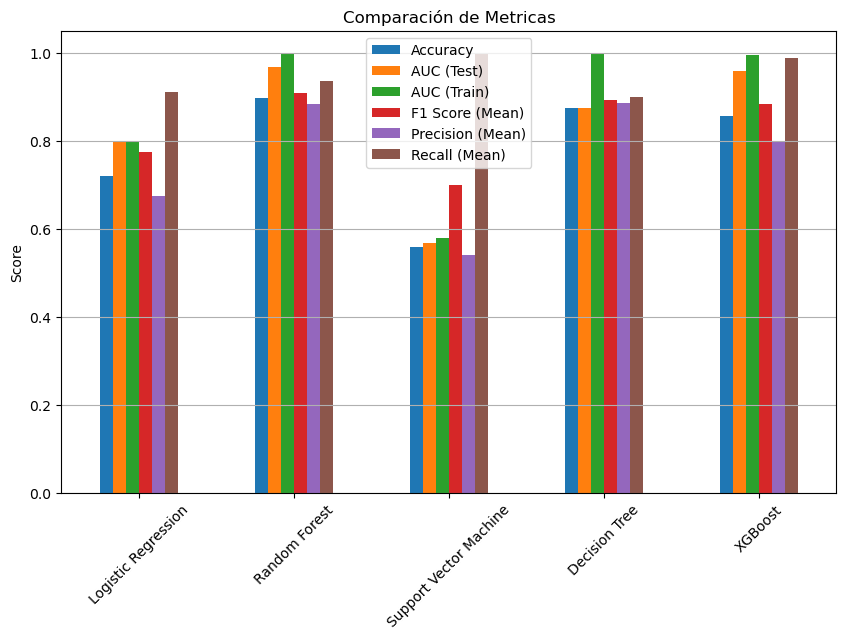

In [80]:
# Plot model performance
summary_matrix.plot(kind='bar', figsize=(10, 6))
plt.title('Comparación de Metricas')
plt.ylabel('Score')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()

# Conclusión

Dado que no se posee mayor contexto sobre el problema y la data y basandonos en las metricas requeridas en el ejericio es que el modelo seleccionado es el Random Forest, Esto debido a que:
    - Tiene el mejor accuracy
    - Tiene el mejor AUC de Test
Si bien el train AUC es de 1 lo que implica una clasificación perfecta(lo cual es improbable en la vida real) en el contexto
del problema presentado podemos aceptarlo.


## Comentario extra
Con respecto al análisis exploratorio de datos (EDA), al tener un mayor entendimiento de la data, podríamos haber generado algún tipo de control de outliers o normalización de variables para que estuvieran en escalas más "similares".

En cuanto al muestreo, tomando en consideración que la clase minoritaria de la variable "target" contenía muy pocos registros, se realizó un oversampling con SMOTE. En otra circunstancia, se podría haber realizado un undersampling y comparado ambos resultados.

Otro punto a tener en consideración es que la diferencia entre los modelos no es tan abismal (a excepción del SVM), por lo que, incluso si estamos dispuestos a sacrificar un poco de score en las métricas, podríamos optar por la regresión logística para ganar en explicabilidad. Todo esto dentro del marco de que el número de registros es bajo; si esto se escalara a un problema de Big Data, tendríamos que considerar también el tiempo y costo de procesamiento.